In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [13]:
def k_fold_cross_validation(model, X, y, k=5, random_state=15):
    """
    Perform k-fold cross-validation for a given model.
    
    Args:
        model: The machine learning model to evaluate.
        X: Feature matrix (numpy array).
        y: Target vector (numpy array).
        k: Number of folds (default is 5).
        random_state: Random seed for reproducibility (default is None).

    Returns:
        - mean_val_error: The average validation error across k folds.
        - fold_errors: List of validation errors for each fold.
    """
    n_samples = len(X)
    indices = np.arange(n_samples)

    if random_state is not None:
        np.random.seed(random_state)
    np.random.shuffle(indices)

    fold_size = n_samples // k
    fold_errors = []

    for i in range(k):
        val_indices = indices[i * fold_size : (i + 1) * fold_size]
        train_indices = np.setdiff1d(indices, val_indices)

        X_train_fold, X_val_fold = X[train_indices], X[val_indices]
        y_train_fold, y_val_fold = y[train_indices], y[val_indices]

        model.fit(X_train_fold, y_train_fold)
        y_val_pred = model.predict(X_val_fold)
        val_accuracy = accuracy_score(y_val_fold, y_val_pred)
        val_error = 1 - val_accuracy
        fold_errors.append(val_error)

    mean_val_error = np.mean(fold_errors)
    return mean_val_error

In [14]:
# Load preprocessed data
train_images = np.load('train_images_flat.npy')
train_labels = np.load('train_labels_noisy.npy')
train_images_subset = np.load('train_images_flat_subset.npy')
train_labels_subset = np.load('train_labels_noisy_subset.npy')
test_images = np.load('test_images_flat.npy')
test_labels = np.load('test_labels_binary.npy')

hidden_layers = [(50,), (100,), (200,), (300,), (50, 50), (100, 50), (200, 100), (300, 200)]
activations = ['relu', 'tanh', 'logistic']
regularizations = [0.0001, 0.001, 0.01]
solvers = ['adam', 'sgd']

In [15]:
# Find the best hyperparameter configuration using k-fold cross-validation
best_config = None
best_error = np.inf

for layer in hidden_layers:
    for activation in activations:
        for alpha in regularizations:
            for solver in solvers:
                # Create the model
                model = MLPClassifier(
                    hidden_layer_sizes=layer,
                    activation=activation,
                    alpha=alpha,
                    solver=solver,
                    max_iter=5000,  # Fixed number of epochs
                    early_stopping=True,
                    random_state=15
                )
                # Perform k-fold cross-validation
                mean_val_error = k_fold_cross_validation(model, train_images_subset, train_labels_subset)

                # Track the best configuration
                if mean_val_error < best_error:
                    best_error = mean_val_error
                    best_config = {
                        'hidden_layer_sizes': layer,
                        'activation': activation,
                        'alpha': alpha,
                        'solver': solver
                    }

print("Best hyperparameter configuration:", best_config)
print("Best validation error:", best_error)

Best hyperparameter configuration: {'hidden_layer_sizes': (50, 50), 'activation': 'relu', 'alpha': 0.001, 'solver': 'adam'}
Best validation error: 0.487


In [16]:
# Train the final model on the full training set using the best configuration
final_model = MLPClassifier(
    hidden_layer_sizes=best_config['hidden_layer_sizes'],
    activation=best_config['activation'],
    alpha=best_config['alpha'],
    solver=best_config['solver'],
    max_iter=5000,
    early_stopping=True,
    random_state=15
)
final_model.fit(train_images, train_labels)

# Evaluate on the test set
test_predictions = final_model.predict(test_images)
test_accuracy = accuracy_score(test_labels, test_predictions)
test_error = 1 - test_accuracy

print(f"Test error with best configuration: {test_error}")

Test error with best configuration: 0.025499999999999967


Hidden Layer Config: (10,), Training Error: 0.0128, Test Error: 0.0250
Hidden Layer Config: (50,), Training Error: 0.0123, Test Error: 0.0245
Hidden Layer Config: (100,), Training Error: 0.0102, Test Error: 0.0220
Hidden Layer Config: (50, 50), Training Error: 0.0118, Test Error: 0.0250
Hidden Layer Config: (100, 50), Training Error: 0.0023, Test Error: 0.0180
Hidden Layer Config: (200, 100), Training Error: 0.0042, Test Error: 0.0190
Hidden Layer Config: (300, 200), Training Error: 0.0024, Test Error: 0.0155
Hidden Layer Config: (400, 300), Training Error: 0.0021, Test Error: 0.0170
Hidden Layer Config: (500, 400), Training Error: 0.0037, Test Error: 0.0170

Best Training Error: 0.002083333333333326
Best Test Error: 0.015499999999999958
Best Hidden Layer Config: (300, 200)


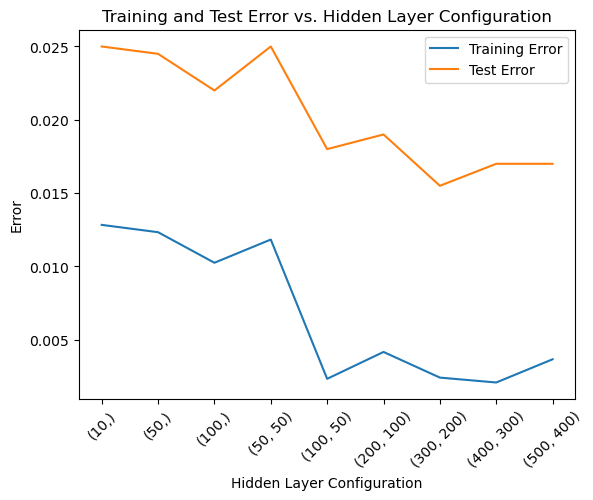

In [21]:
# Experiment 1: Vary the hidden layer configurations
hidden_layer_configs = [
    (10,),           # Single hidden layer with 10 nodes
    (50,),           # Single hidden layer with 50 nodes
    (100,),          # Single hidden layer with 100 nodes
    (50, 50),        # Two hidden layers with 50 nodes each
    (100, 50),       # Two hidden layers with 100 and 50 nodes
    (200, 100),      # Two hidden layers with 200 and 100 nodes
    (300, 200),      # Two hidden layers with 300 and 200 nodes
    (400, 300),      # Two hidden layers with 400 and 300 nodes
    (500, 400)       # Two hidden layers with 500 and 400 nodes
]

training_errors = []
test_errors = []

# Initialize variables to track the best errors
best_training_error = np.inf
best_test_error = np.inf
best_config = None

for config in hidden_layer_configs:
    model = MLPClassifier(
        hidden_layer_sizes=config,
        activation='relu',  # Fixed activation for this experiment
        alpha=0.0001,       # Fixed regularization for this experiment
        solver='adam',      # Fixed solver for this experiment
        max_iter=5000,
        early_stopping=True,
        random_state=15
    )
    model.fit(train_images, train_labels)

    # Compute training error
    train_predictions = model.predict(train_images)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_error = 1 - train_accuracy
    training_errors.append(train_error)

    # Compute test error
    test_predictions = model.predict(test_images)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

    # Track the best errors and corresponding configuration
    if train_error < best_training_error:
        best_training_error = train_error
    if test_error < best_test_error:
        best_test_error = test_error
        best_config = config

    # Print progress
    print(f"Hidden Layer Config: {config}, Training Error: {train_error:.4f}, Test Error: {test_error:.4f}")

# Output the best errors
print("\nBest Training Error:", best_training_error)
print("Best Test Error:", best_test_error)
print("Best Hidden Layer Config:", best_config)

# Plot results for Experiment 1
x_labels = [str(config) for config in hidden_layer_configs]  # Convert configs to strings for plotting
plt.plot(x_labels, training_errors, label="Training Error")
plt.plot(x_labels, test_errors, label="Test Error")
plt.xlabel("Hidden Layer Configuration")
plt.ylabel("Error")
plt.title("Training and Test Error vs. Hidden Layer Configuration")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.show()

c:\Users\abrau\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Epochs: 10, Training Error: 0.0196, Test Error: 0.0285


c:\Users\abrau\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(


Epochs: 50, Training Error: 0.0050, Test Error: 0.0220


c:\Users\abrau\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (75) reached and the optimization hasn't converged yet.
  warnings.warn(


Epochs: 75, Training Error: 0.0001, Test Error: 0.0160


c:\Users\abrau\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Epochs: 100, Training Error: 0.0000, Test Error: 0.0150
Epochs: 200, Training Error: 0.0000, Test Error: 0.0155
Epochs: 300, Training Error: 0.0000, Test Error: 0.0155


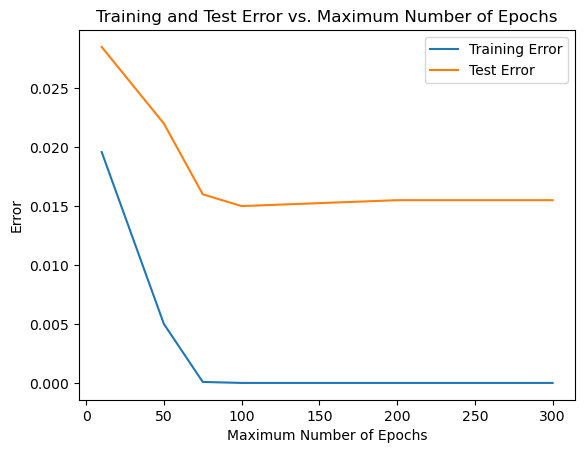

In [26]:
# Experiment 2: Vary the maximum number of epochs
epoch_values = [10, 50, 75, 100, 200, 300]  # Example values
training_errors = []
test_errors = []

for epochs in epoch_values:
    model = MLPClassifier(
        hidden_layer_sizes=(100,),  # Fixed hidden layer size for this experiment
        activation='relu',          # Fixed activation for this experiment
        alpha=0.0001,               # Fixed regularization for this experiment
        solver='adam',              # Fixed solver for this experiment
        max_iter=epochs,
        early_stopping=False,       # Disable early stopping for debugging
        random_state=15
    )
    model.fit(train_images, train_labels)

    # Compute training error
    train_predictions = model.predict(train_images)
    train_accuracy = accuracy_score(train_labels, train_predictions)
    train_error = 1 - train_accuracy
    training_errors.append(train_error)

    # Compute test error
    test_predictions = model.predict(test_images)
    test_accuracy = accuracy_score(test_labels, test_predictions)
    test_error = 1 - test_accuracy
    test_errors.append(test_error)

    # Print progress
    print(f"Epochs: {epochs}, Training Error: {train_error:.4f}, Test Error: {test_error:.4f}")

# Plot results for Experiment 2
plt.plot(epoch_values, training_errors, label="Training Error")
plt.plot(epoch_values, test_errors, label="Test Error")
plt.xlabel("Maximum Number of Epochs")
plt.ylabel("Error")
plt.title("Training and Test Error vs. Maximum Number of Epochs")
plt.legend()
plt.show()